In [1]:
import numpy as np
import cv2, glob, os, re
import pandas as pd
import pylab as plt
from xml.etree import ElementTree as et
import pickle

## 将图片整理成字典

In [2]:
# 分段图放在这里
# 路径中不要有中文字符
slices_img_path = r'D:\OneDrive\MyDrive\OneDrive\Projects\longi\longi-slide-images-60\only_slice'

In [3]:
slice_img_list = glob.glob(os.path.join(slices_img_path, r'*H.jpg'))

pic_dict = {re.split('_', os.path.basename(k))[0]:{} for k in slice_img_list}
for p in slice_img_list:
    pic_dict[re.split('_', os.path.basename(p))[0]][re.findall('([A-C]\d)H', p)[0]] = p

pic_dict['LRP503033190701001501']

{'A1': 'D:\\OneDrive\\MyDrive\\OneDrive\\Projects\\longi\\longi-slide-images-60\\only_slice\\LRP503033190701001501_A1H.jpg',
 'A2': 'D:\\OneDrive\\MyDrive\\OneDrive\\Projects\\longi\\longi-slide-images-60\\only_slice\\LRP503033190701001501_A2H.jpg',
 'A3': 'D:\\OneDrive\\MyDrive\\OneDrive\\Projects\\longi\\longi-slide-images-60\\only_slice\\LRP503033190701001501_A3H.jpg',
 'A4': 'D:\\OneDrive\\MyDrive\\OneDrive\\Projects\\longi\\longi-slide-images-60\\only_slice\\LRP503033190701001501_A4H.jpg',
 'B1': 'D:\\OneDrive\\MyDrive\\OneDrive\\Projects\\longi\\longi-slide-images-60\\only_slice\\LRP503033190701001501_B1H.jpg',
 'B2': 'D:\\OneDrive\\MyDrive\\OneDrive\\Projects\\longi\\longi-slide-images-60\\only_slice\\LRP503033190701001501_B2H.jpg',
 'B3': 'D:\\OneDrive\\MyDrive\\OneDrive\\Projects\\longi\\longi-slide-images-60\\only_slice\\LRP503033190701001501_B3H.jpg',
 'B4': 'D:\\OneDrive\\MyDrive\\OneDrive\\Projects\\longi\\longi-slide-images-60\\only_slice\\LRP503033190701001501_B4H.jpg',


## 生成golden unit

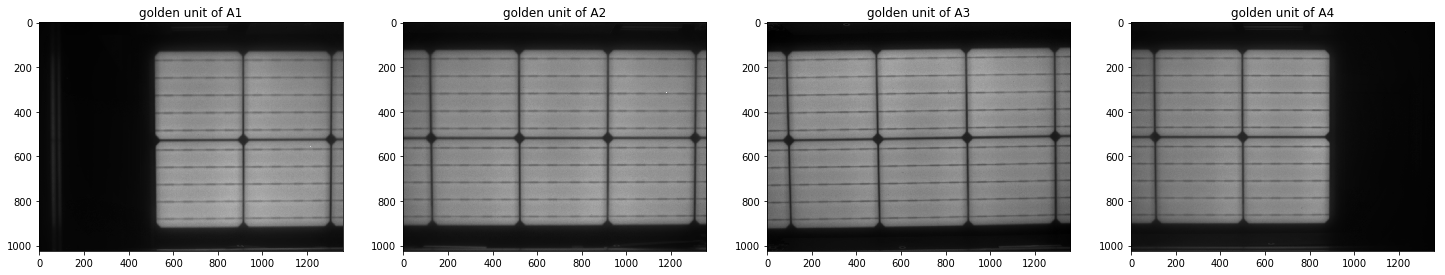

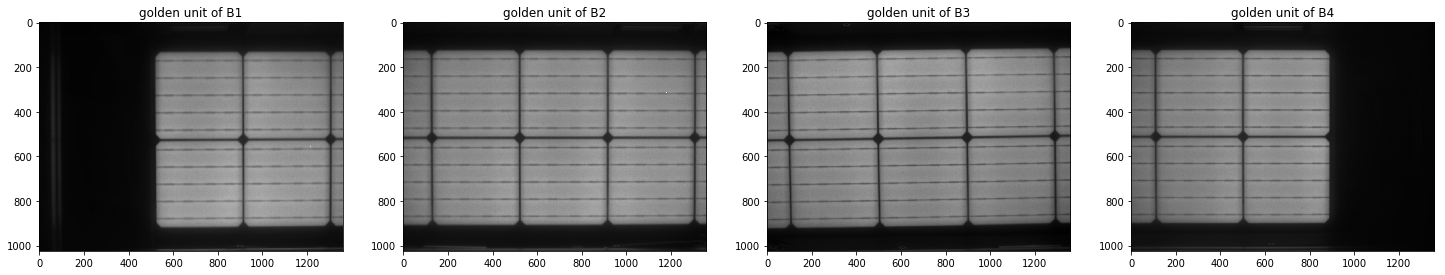

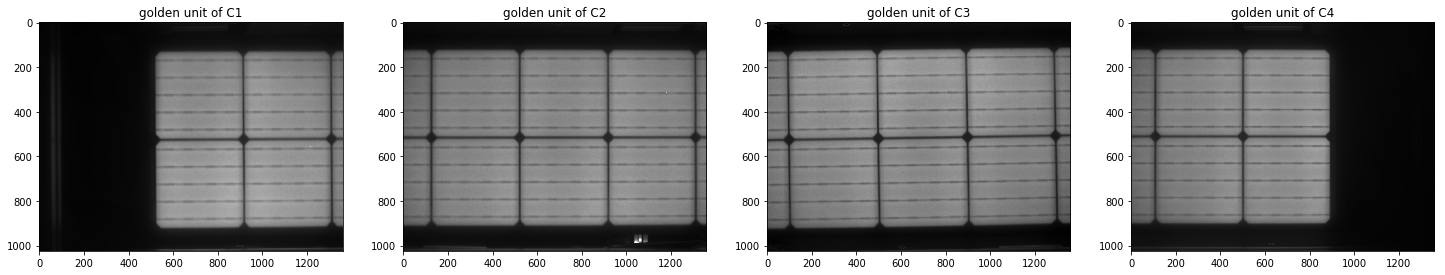

In [5]:
plt.rc('figure', figsize = (25, 8))
GOLDEN_UNIT_DICT = {}
for s in ['A', 'B', 'C']:
    for i in range(1,5):
        piece1 = []
        for v in pic_dict.values():
            piece1.append(cv2.imread(v['%s%i' % (s, i)], 0))
        piece1 = np.array(piece1)
        gu_piece1 = piece1.mean(0)
        # 构建一次金字塔
        GOLDEN_UNIT_DICT['%s%i' % (s, i)] = cv2.pyrDown(gu_piece1.astype(np.uint8))
        plt.subplot(1, 4, i)
        plt.title('golden unit of %s%i' % (s, i))
        plt.imshow(gu_piece1, 'gray')
        cv2.imwrite('./golden_units/longi_M2L2_60_%s%i.jpg' % (s, i), gu_piece1)
        if i == 4:
            plt.show()

## 下一步：把Golden unit下载下来，打标签~
golden unit保存在ipynb所在文件夹的golden_units文件夹里面。<br>
**标签需知**：<br>
用labelimg打框，保证框的左上角点对齐角点位置。<br>
千万对齐不要打歪<br>

## 根据打的标签，生成golden_corners
把打好的标签上传上来。运行下面cell，观察一下是否点都是对的，以及数字是否是顺时针0123的顺序。

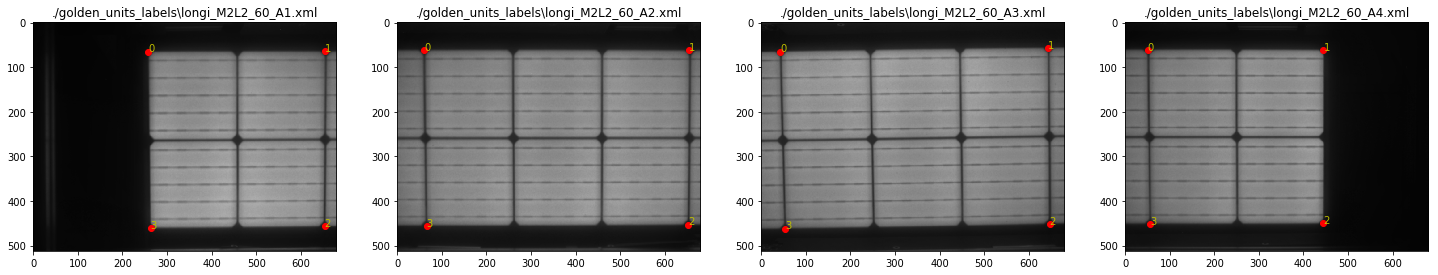

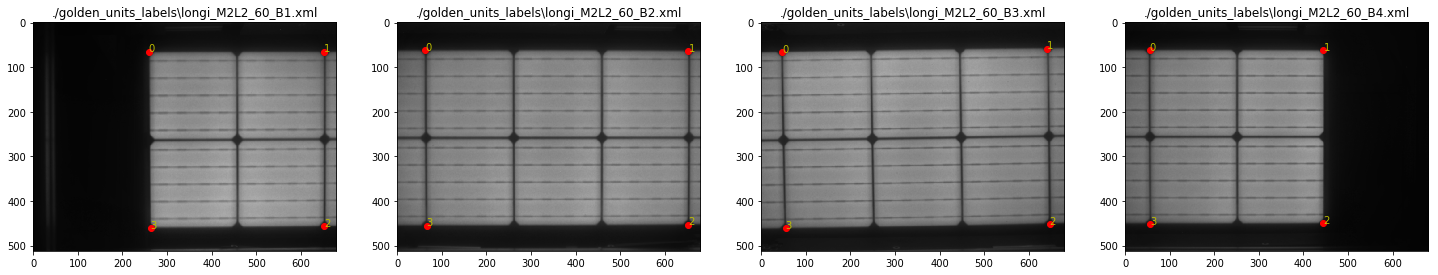

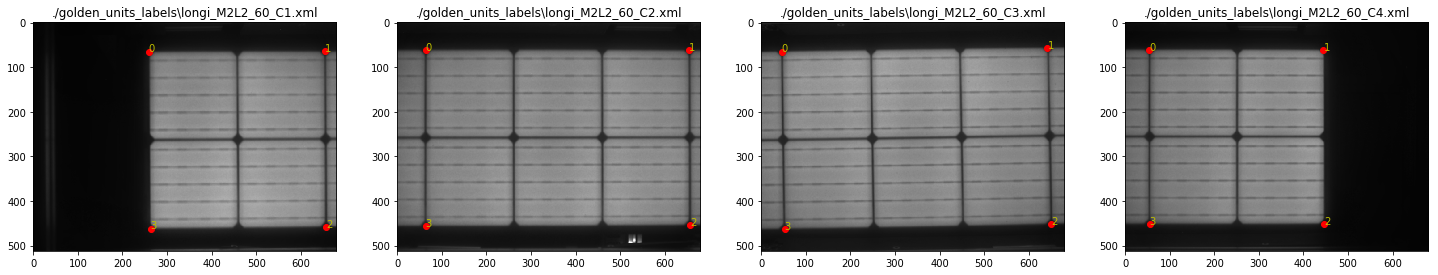

In [9]:
#get corners
def parse_objs_from_xml(xml_file):
    with open(xml_file) as f:
        tree = et.parse(f)
        root = tree.getroot()
    objs = []
    for o in tree.findall('object'):
        obj = {}
        obj['name'] = o.find('name').text
        obj['bndbox'] = []
        for pos in ['xmin', 'ymin', 'xmax', 'ymax']:
            obj['bndbox'].append(int(o.find('bndbox').find(pos).text))
        objs.append(obj)

    return objs

def reorg_dots(dots):
    dots = np.array(dots)
    sumxy = dots.sum(1)
    lt = dots[sumxy.argmin()]
    rd = dots[sumxy.argmax()]
    others = dots[np.argsort(sumxy)[1:-1]]
#     print(others)
    rt = others[others[:, 0].argmax()]
    ld = others[others[:, 0].argmin()]
    
    return np.array([lt, rt, rd, ld])

GOLDEN_CORNER_DICT = {}
k = 0
for xml in glob.glob(r'./golden_units_labels/*.xml'):
    objs = parse_objs_from_xml(xml)
    img = cv2.imread(r'./golden_units/%s.jpg' % os.path.basename(xml).split('.')[0])
    plt.subplot(1, 4, k % 4 + 1)
    plt.imshow(cv2.pyrDown(img), 'gray')
    plt.title(xml)
    
    corners = np.array([obj['bndbox'][:2] for obj in objs])
    corners = reorg_dots(corners)
    corners = np.uint(corners / 2)
#     print(xml.split('.')[1])
    GOLDEN_CORNER_DICT['%s' % xml.split('.')[1][-2:]] = corners
    i = 0
    for x, y in corners:
#         plt.scatter(x, y, c = 'r')
        plt.annotate(str(i), xy = (x, y), color = 'y')
        i += 1
    xs, ys = corners.T
    plt.scatter(xs, ys, c = 'r')
    k += 1
    if k % 4 == 0:
        plt.show()

## 将GOLDEN_UNIT和GOLDEN_CORNER写入配置文件pkl

In [10]:
golden_parameters = {"GOLDEN_UNIT_DICT": GOLDEN_UNIT_DICT, "GOLDEN_CORNER_DICT": GOLDEN_CORNER_DICT}
with open(r'./utils/longi_concat_parameters_60.pkl', 'wb') as f:
    pickle.dump(golden_parameters, f)

## 下面是inference部分的集成测试

In [2]:
%load_ext autoreload
%autoreload 2
from utils.concat_pics_longi_V1 import *
import pylab as plt
import time
plt.rc('figure', figsize = (25, 8))

# for k, v in pic_dict.items():
#     for s in ['A', 'B', 'C']:
#         img_list = [cv2.imread(v['%s%i' % (s, i)]) for i in range(1,5)]
#         tic = time.time()
#         concat_4 = joint_image(img_list, s)
#         toc = time.time()
#         plt.title(k + s)
#         plt.imshow(concat_4, 'gray')
#         plt.show()
#         print('%.4f' % (toc - tic))